# Data analysis - `keras`

In [ ]:
import os
import numpy as np
import pickle
import nibabel as nb
import pandas as pd
from scipy.stats import zscore
from keras import layers, models, optimizers, regularizers
from random import shuffle

/home/line/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Create dataset

In [ ]:
def read_dataset(filename, outlier_thr=5):

    # Read csv file
    df = pd.read_csv(filename)

    # extract relevant variables
    sub_id = np.array(df['PAC_ID'])
    label = np.array(df['Label'] - 1)
    df = df.drop(['PAC_ID', 'Label'], 1)
    header = df.keys()
    
    # Clean dataset - drop subjects with values above `outlier_thr` STD
    outliers = np.sum((np.abs(zscore(df)) > outlier_thr), 1) != 0
    print('%d outliers detected.' % outliers.sum())
    data = np.array(df.drop(np.where(outliers)[0]))
    sub_id = sub_id[np.invert(outliers)]
    label = label[np.invert(outliers)]
    
    # zscore data
    data = zscore(data)

    # Reset Gender and Scanner values to nominal values
    data[:,1] = (data[:,1]>0) + 1
    data[:,3] = [np.where(i==np.unique(data[:,3]))[0][0] + 1for i in data[:,3]]

    return pd.DataFrame(data, columns=header), sub_id, label

In [ ]:
data, sub_id, label = read_dataset('data/PAC2018_Covariates_detailed.csv', outlier_thr=5)
data.head()

8 outliers detected.


,Age,Gender,TIV,Scanner,Tvoxels,Tmean,Tmedian,Tstd,Tmax,Left_Frontal_Pole,...,Right_Cerebral_White_Matter,Right_Cerebral_Cortex,Right_Lateral_Ventricle,Right_Thalamus,Right_Caudate,Right_Putamen,Right_Pallidum,Right_Hippocampus,Right_Amygdala,Right_Accumbens
0,1.610405,1.0,1.479924,2.0,-0.890455,1.091014,1.080367,1.034026,0.060878,1.096927,...,1.093750,1.094903,1.037705,-0.896948,-0.255150,-0.724690,-0.269052,1.791264,1.591691,0.091529
1,-1.146076,1.0,-0.052883,1.0,1.134709,-0.118805,-0.147065,0.290905,0.904814,0.017488,...,-0.060199,-0.013714,0.079673,0.634875,1.097503,0.176912,-0.143525,0.223282,0.283818,-0.110870
2,-0.200997,2.0,-0.322187,2.0,-0.910314,0.213228,0.466651,-0.390523,0.488056,-0.281768,...,0.167886,0.162364,0.443724,0.107536,-0.337023,-0.458773,-0.199329,0.879846,0.603997,0.182364
3,-0.200997,1.0,1.526994,3.0,-0.888128,1.178024,1.141739,1.173458,0.863138,0.754654,...,1.022908,1.000870,2.157792,1.573471,2.835140,1.080137,0.815276,0.185643,0.730864,2.010200
4,2.004188,2.0,-0.934370,1.0,1.027570,-2.074238,-2.049584,-2.070608,-0.824733,-2.118870,...,-2.148225,-2.165083,-1.193547,-1.593558,-2.270355,-1.290505,-1.337832,-1.919742,-2.127827,-1.856324


# Create dataset (select dataset, balance it and divide train and validation)

In [ ]:
def balance_dataset(sub_id, labels, data):
    max_label_size = np.min([np.sum(lab == labels) 
                             for lab in np.unique(labels)])

    labels_1 = np.where(labels == 0)[0]
    np.random.shuffle(labels_1)
    labels_1 = labels_1[:max_label_size]

    labels_2 = np.where(labels == 1)[0]
    np.random.shuffle(labels_2)
    labels_2 = labels_2[:max_label_size]

    new_data_id = np.hstack((labels_1, labels_2))
    np.random.shuffle(new_data_id)
    labels = labels[new_data_id]
    sub_id = sub_id[new_data_id]
    data = data[new_data_id]

    return (sub_id, labels, data)

In [ ]:
def get_train_valid_set(sub_id, label, data, group='123', train_ratio=0.8):
    
    selecter = [str(int(d)) in group for d in data.Scanner]

    group_sub, group_label, group_data = balance_dataset(
        sub_id[selecter], label[selecter], np.array(data[selecter]))
    
    
    train_size = int(len(group_sub) * train_ratio)
    valid_size = len(group_sub) - train_size

    counter1 = 0
    counter2 = 0
    train_list = []

    for i, s in enumerate(group_sub):
        if counter1 < (train_size / 2) and group_label[i] == 0:
            train_list.append(s)
            counter1 += 1
        elif counter2 < (train_size / 2) and group_label[i] == 1:
            train_list.append(s)
            counter2 += 1

    selecter = np.array([True if e in train_list else False for i, e in enumerate(group_sub)])

    train_list = group_sub[selecter]
    valid_list = group_sub[np.invert(selecter)]
    
    return train_list, valid_list, group_sub, group_label, group_data

# `Keras` model

In [ ]:
def data_gen(fileList, batch):

    while True:
        for r in range(0, len(fileList), batch):

            batch_data_table = []
            batch_data_image = []
            batch_label = []

            for i in range(batch):
                if r + i >= len(fileList):
                    break
                else:

                    patientID = fileList[r]

                    # Get data for each subject (table and image)
                    batch_data_table.append(group_data[group_sub == patientID][0])

                    f = 'data/nifti/%s.nii.gz' % patientID

                    # Get data for each subject
                    img = nb.load(f).get_fdata()
                    img = img[15:105, 15:125, 15:100]

                    batch_data_image.append(img)
                    
                    # Get data for each label
                    labelID = group_label[group_sub == patientID]
                    batch_label.append(labelID)

            yield ([np.array(batch_data_table), np.array(batch_data_image)],
                    np.array(batch_label))

In [ ]:
input1 = layers.Input(shape=(126, ))
x1 = layers.Dense(32, )(input1)
x1 = layers.Dense(32, activation='relu')(x1)
x1 = layers.Dense(32, activation='relu')(x1)

input2 = layers.Input(shape=(90, 110, 85, ))
x2 = layers.Conv2D(32, (3, 3), activation='relu')(input2)
x2 = layers.Conv2D(32, (3, 3), activation='relu')(x2)
x2 = layers.MaxPooling2D((2, 2))(x2)
x2 = layers.Conv2D(64, (3, 3), activation='relu')(x2)
x2 = layers.Conv2D(64, (3, 3), activation='relu')(x2)
x2 = layers.MaxPooling2D((2, 2))(x2)

x2 = layers.Conv2D(32, (3, 3), activation='relu')(x2)
x2 = layers.MaxPooling2D((3, 3))(x2)
x2 = layers.Flatten()(x2)
x2 = layers.Dense(32, activation='relu', name='hidden-1')(x2)

merger = layers.concatenate([x1, x2])
out = layers.Dense(16, activation='relu')(merger)
out = layers.Dense(1, activation='sigmoid', name='output')(out)

model = models.Model(inputs=[input1, input2], outputs=out)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 90, 110, 85)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 88, 108, 32)  24512       input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 86, 106, 32)  9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 43, 53, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [ ]:
# Batch size
batch_size = 20

# Training to Validation set ratio
train_ratio=0.8

In [ ]:
# Create Groups
group_id = '123'
train_list, valid_list, group_sub, group_label, group_data = get_train_valid_set(
    sub_id, label, data, group=group_id, train_ratio=0.8)

In [ ]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [ ]:
history = model.fit_generator(
    data_gen(train_list, batch_size),
    steps_per_epoch=int(np.ceil(len(train_list) / batch_size)),
    validation_data=data_gen(valid_list, batch_size),
    validation_steps=int(np.ceil(len(valid_list) / batch_size)),
    epochs=20, shuffle=True)

Epoch 1/20
61/61 [==============================] - 64s 1s/step - loss: 0.6790 - binary_accuracy: 0.5409 - val_loss: 0.7158 - val_binary_accuracy: 0.3974
Epoch 2/20
61/61 [==============================] - 63s 1s/step - loss: 0.6722 - binary_accuracy: 0.5411 - val_loss: 0.7032 - val_binary_accuracy: 0.4636
Epoch 3/20
61/61 [==============================] - 77s 1s/step - loss: 0.6673 - binary_accuracy: 0.5411 - val_loss: 0.6939 - val_binary_accuracy: 0.5298
Epoch 4/20
61/61 [==============================] - 81s 1s/step - loss: 0.6629 - binary_accuracy: 0.5247 - val_loss: 0.6864 - val_binary_accuracy: 0.5960
Epoch 5/20
61/61 [==============================] - 80s 1s/step - loss: 0.6585 - binary_accuracy: 0.5411 - val_loss: 0.6794 - val_binary_accuracy: 0.5960
Epoch 6/20
61/61 [==============================] - 81s 1s/step - loss: 0.6542 - binary_accuracy: 0.5739 - val_loss: 0.6741 - val_binary_accuracy: 0.5960
Epoch 7/20
61/61 [==============================] - 80s 1s/step - loss: 0.65

# Visualize results

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

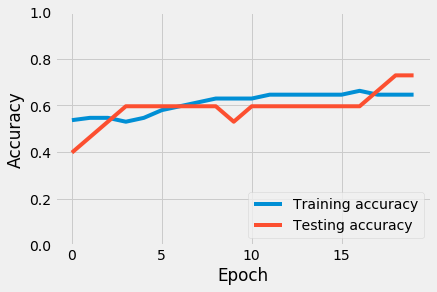

In [ ]:
plt.style.use('fivethirtyeight')
plt.plot(history.history['binary_accuracy'], label='Training accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Testing accuracy')
plt.ylim([0,1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=4)

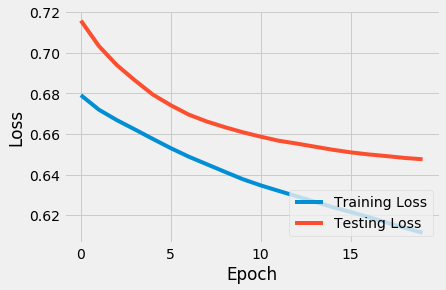

In [ ]:
plt.style.use('fivethirtyeight')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=4)